In [1]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numba to make things faster
import numba

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}


# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Fetch Data and Standardize Results to prepare for MCMC

In [2]:
input_path = '../input/rnai_screen_results/'
output_path = '../output/rnai_screen_results/'

df = pd.read_csv(input_path + 'rnai_heat_shock_data.txt', sep='\t')
names = pd.read_csv(input_path + 'rnai_genes_dict.csv')
names.head()

# rename the columns to something handy
df.columns = ['rnai', 'alive', 'dead', 'date']

# make all codes upper or lower, not both
# first make sure each column is a str
names.code = names.code.apply(str)
df.rnai = df.rnai.apply(str)
# now apply lower
names.code = names.code.apply(str.lower)
df.rnai = df.rnai.apply(str.lower)

# extract the names that have been assayed so far
def translate(x):
    """A function to go between rnai code and gene (human-readable) name."""
    return names[names.code == x].gene_name.values[0]

df['gene'] = df.rnai.apply(translate)

df.sort_values('gene', inplace=True)

# calculate fraction dead
df['fraction_dead'] = df.dead/(df.alive + df.dead)


# standardize dead values to the mean and stdev of the gfp data
gfp_fr_dead_mu = df.fraction_dead.mean()
gfp_fr_dead_sig = df.fraction_dead.std()
total = (df.dead+df.alive)

df['z_dead'] = (df.dead - total*gfp_fr_dead_mu)/(gfp_fr_dead_sig*total)


# Toy MCMC to make sure I can implement justin's good-bad model (i.e., not hierarchical)

In [189]:
def log_posterior_good_bad(p, x):
    """
    The log posterior for the good/bad data model for repeated
    measurements.
    
    params:
    -------
    p - the parameters. First three params must be mu, sigma, and sigma_bad
    x - data to fit the model to
    
    output:
    log_prior + log_like - a scalar number
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
        
    # Check to make sure the prior conditions are ok
#     for k in g:
#         if k < 0.0:
#             return -np.inf
#         if k > 1.0:
#             return -np.inf
        
#     if not all(g > 0.0):
#         return -np.inf
    
#     if not all(g < 1.0):
#         return -np.inf
    
#     if sigma <= 0 or sigma_bad < sigma:
#         return -np.inf
    
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf
    
    # log prior
    log_prior = -np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log((1-g) / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log(g / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()
    
    # Return the whole posterior
    return log_prior + log_like - np.sum(g)


In [140]:
def mcmc(target, n_walkers=200, n_burn=2000, n_steps=5000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.
    params:
    -------
    target -- a string that specifies which gene to draw data from
    n_walkers -- number of walkers
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    if target not in df.gene.unique():
        raise ValueError('target must be in df.gene.unique')
    
    n_dim = 3 + len(df[df.gene == target])  # number of parameters in the model
    
    med_val = df[df.gene == target].z_dead.median()
    
    # Seed random number generator for reproducibility
    np.random.seed(42)

    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    p0[:, 0] = np.random.normal(med_val, 0.1, n_walkers)                # mu
    p0[:, 1] = np.random.exponential(1.0, n_walkers)               # sigma
    p0[:, 2] = np.random.exponential(5.0, n_walkers)              # sigma_bad
    p0[:, 3:] = np.random.uniform(0.0, 1.0, (n_walkers, n_dim-3))  # g_i

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_good_bad,
                                args=(df[df.gene == target].z_dead,),
                                threads=6)

    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler


In [142]:
def fetch_params(sampler):
    """A function that, given an emcee sampler, takes out the likeliest mean, sem and sigma."""
    max_ind = np.argmax(sampler.flatlnprobability)
    mean_goodbad = sampler.flatchain[max_ind, 0]
    sigma = sampler.flatchain[max_ind, 1]
    # Get the error bar
    sem_goodbad = sampler.flatchain[:, 0].std()
    
    return mean_goodbad, sigma, sem_goodbad

# That seemed to work. Now, set up a parallel mcmc function to calculate good-bad values for each strain -- this is approaching the level of unpacking required for us to deploy a full hierarchical model

In [4]:
def parallel_log_posterior_good_bad(P, df):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    grouped = df.groupby('gene')
    
    t_len = len(target)
    
    lp = 0
    
    n_data = 0
    i = 0
    for name, group in grouped:
        
        #extract the data
        x = group.z_dead

        data_points = len(group)
        
        #extract correct parameter set
        mu = P[i]
        sigma = P[t_len + i]
        sigma_bad = P[2*t_len + i]
        g = P[3*t_len+n_data: 3*t_len+n_data+data_points]
        
        if len(g) != len(x):
            raise ValueError('g must be same length as x')        
        
        p = np.array([mu, sigma, sigma_bad])
        p = np.concatenate((p, g))
        
        #update the parameter indices
        n_data += data_points  
        i += 1
                      
        #update log posterior
        lp += log_posterior_good_bad(p, x)
 

    return lp


In [5]:
def parallel_mcmc(target, n_walkers=200, n_burn=2000, n_steps=5000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    n_walkers -- number of walkers
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    for t in target:
        if t not in df.gene.unique():
            print(t)
            raise ValueError('all targets must be in df.gene.unique')
    
    df1 = df[df.gene.isin(target)]
    grouped = df1.groupby('gene')
    
    if type(target) is str:
        target = [target]
        

    n_dim = 3*len(target) + len(df1)  # number of parameters in the model
    n_walkers = 200 + 2*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    i = 0 
    n_data = 0
    n_data_tot = len(df1)
    t_len = len(target)
    
    for name, group in grouped:
        
        med_val = group.z_dead.median()
        data_points = len(group)
        
        
        p0[:, i] = np.random.normal(med_val, 0.1, n_walkers)                # mu
        p0[:, t_len + i] = np.random.exponential(1.0, n_walkers)               # sigma
        p0[:, 2*t_len+i] = np.random.exponential(5.0, n_walkers)              # sigma_bad
        
        # there's a different number of data points for each assay so...
        g_i= np.random.uniform(0.0, 1.0, (n_walkers, data_points))  # g_i
        
        p0[:, 3*t_len+n_data: 3*t_len+n_data+data_points] = g_i
        
        n_data += data_points
        i += 1

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, parallel_log_posterior_good_bad,
                                args=(df1,),
                                threads=6)

    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler


In [125]:
def parallel_fetch_params(sampler, target, df=df):
    """A function that, given an emcee sampler, takes out the likeliest mean, sem and sigma."""
    l = len(target)
    
    max_ind = np.argmax(sampler.flatlnprobability)
    
    
    mean_goodbad = np.array([sampler.flatchain[max_ind, 0: l]])
    sigma = np.array([sampler.flatchain[max_ind, l: 2*l]])
    # Get the error bar
    sem_goodbad = np.empty(l)
    for i in range(0, l):
        sem_goodbad[i] = sampler.flatchain[:, i].std()
        
    t= np.array([target])

    t = np.concatenate((t, mean_goodbad, sigma))
    print(t.shape)
    print(sem.shape)
    t = np.concatenate((t, np.array([sem_goodbad])))
    return t

# Try out your parallelized MCMC

This MCMC will ascertain the true mean of each gene RNAi accounting for outliers.
Note:

There are multiple rnai codes that correspond to a single gene.

In [117]:
target = df.gene.unique()
sampler = parallel_mcmc(target, df=df)

In [128]:
d = parallel_fetch_params(sampler, target)

# df contains mean, sigma and sem(mean) of each gene (note, not rnai, there are multiple
# rnai per gene) as a result of the parallelized MCMC we just ran

# place data in a df, coerce to numeric bc numpy matrix was mixed type (str, np.floats)
ind = np.linspace(0, len(target) -1 , len(target)).astype(int)
df_mcmc= pd.DataFrame(index= ind, data=d.T, columns=['target_gene', 'mean_survival', 'sigma', 'sm'])
df_mcmc[['mean_survival', 'sigma', 'sm']] = df_mcmc[['mean_survival',
                                                     'sigma', 'sm']].apply(lambda x: 
                                                                           pd.to_numeric(x, errors='coerce'))

# Prepare for pseudo-hierarchical MCMC -- ie running an MCMC on the afore-calculated means

In [1]:
# my function isn't perfect yet, so for the moment add a placeholder column called 'gene'
# in reality, this column is just so that we can do a second MCMC on the means of each gene
df_mcmc['gene'] = 'z'

# Before proceeding, plot out the data with and without 'outliers' (crudely defined for the moment)
# to ensure they look roughly gaussian, purely as a sanity check
fig, ax = plt.subplots()
sns.distplot(df_mcmc[df_mcmc.gene == 'z'].mean_survival)
plt.title('Distribution of Mean Survival, All Data')
plt.xlim(-2, 2)

fig, ax = plt.subplots()
sns.distplot(df_mcmc[(df_mcmc.gene == 'z') & (df_mcmc.mean_survival.abs() < 1.5)].mean_survival)
plt.title('Distribution of Mean Survival, Data Excluding Large Outliers (Not Processed)')
plt.xlim(-2, 2)

df_mcmc['z_dead']= df_mcmc.mean_survival

NameError: name 'df_mcmc' is not defined

In [ ]:
sampler= mcmc('z', n_walkers= 400, n_steps= 6000, df=df_mcmc)


mean: 0.144477 +/- 0.130054
sigma:     0.525208

1       C14C10.2
2        F11C1.5
3        F14F9.3
4        F21H7.2
5       F54E12.2
6        K07E3.4
8       T05E12.6
9        T05E7.1
10       T12G3.2
11    Y105C5A.13
12     Y39B6A.21
13        acr-17
15        egl-15
16         gei-4
17           gfp
18         haf-9
19         ifb-1
20        tsp-10
21         twk-1
23        unc-43
24        unc-73
Name: target_gene, dtype: object


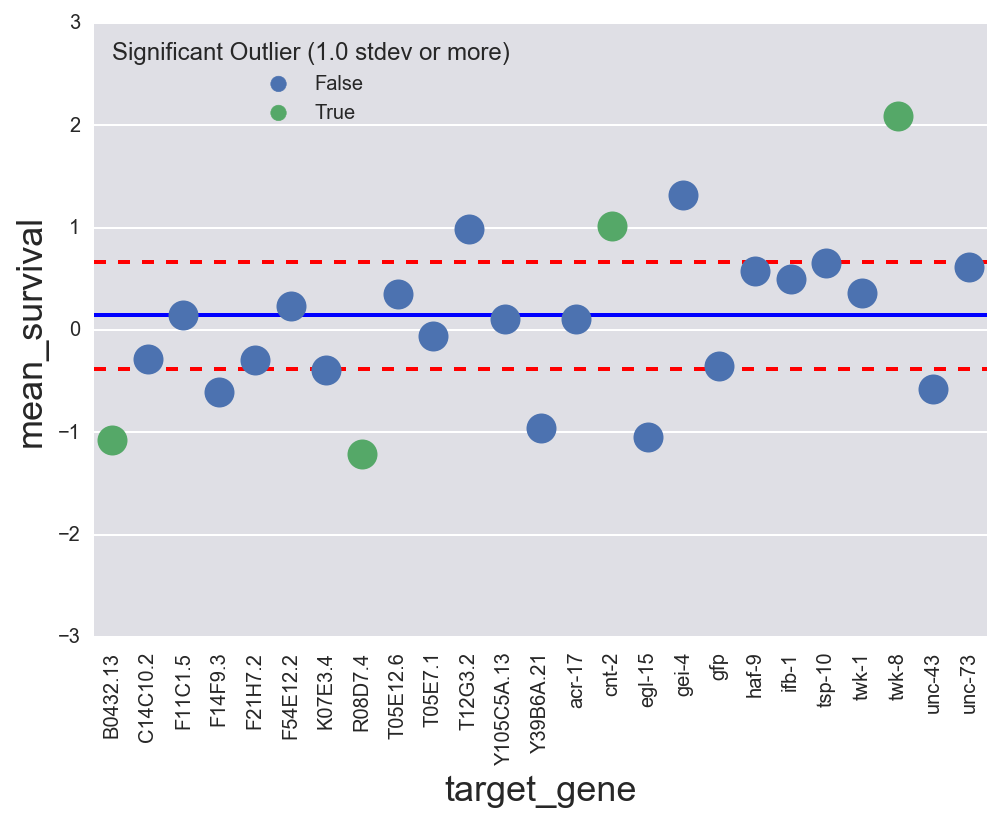

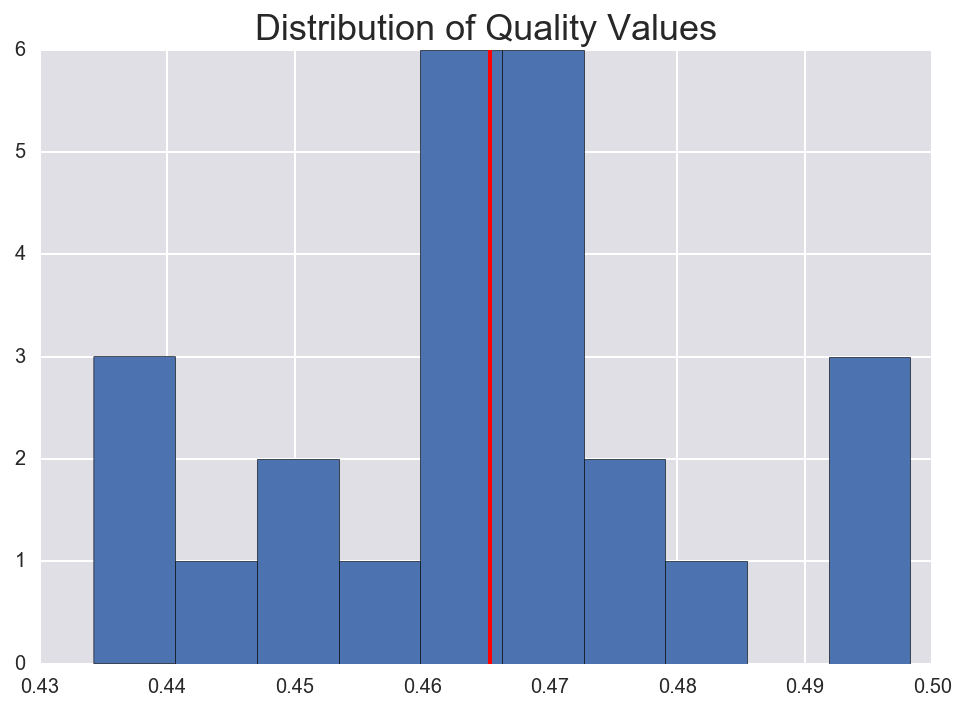

In [231]:
mean, sigma, sem= fetch_params(sampler)

print("""
mean: {0:2f} +/- {1:2f}
sigma:     {2:2f}
""".format(mean, sem, sigma))
g = sampler.flatchain[:, 3:].mean(axis=0)

# Identify outliers
x= 1.0
outliers = (g > g.mean() + x*g.std())

df_mcmc['outliers'] = g
df_mcmc['outliers_boolean'] = outliers

if 'gfp' in df_mcmc[~outliers].target_gene:
    print('UhOh!')
else:
    print(df_mcmc[~outliers].target_gene)

fig, ax= plt.subplots()
sns.swarmplot(x='target_gene', y='mean_survival', hue='outliers_boolean', data=df_mcmc, size= 15)
plt.axhline(mean, color='b')
plt.axhline(mean + sigma, ls='--', color='r')
plt.axhline(mean - sigma, ls='--', color='r')
plt.xticks(rotation=90)
plt.legend(loc='upper left', title= r"Significant Outlier ({0} stdev or more)".format(x))
plt.ylim(-3, 3)
plt.savefig(output_path+'significant_outliers_semihierarchical_mcmc.pdf')

fig, ax = plt.subplots()
plt.hist(g)
plt.axvline(g.mean(), color='r')
plt.title('Distribution of Quality Values')

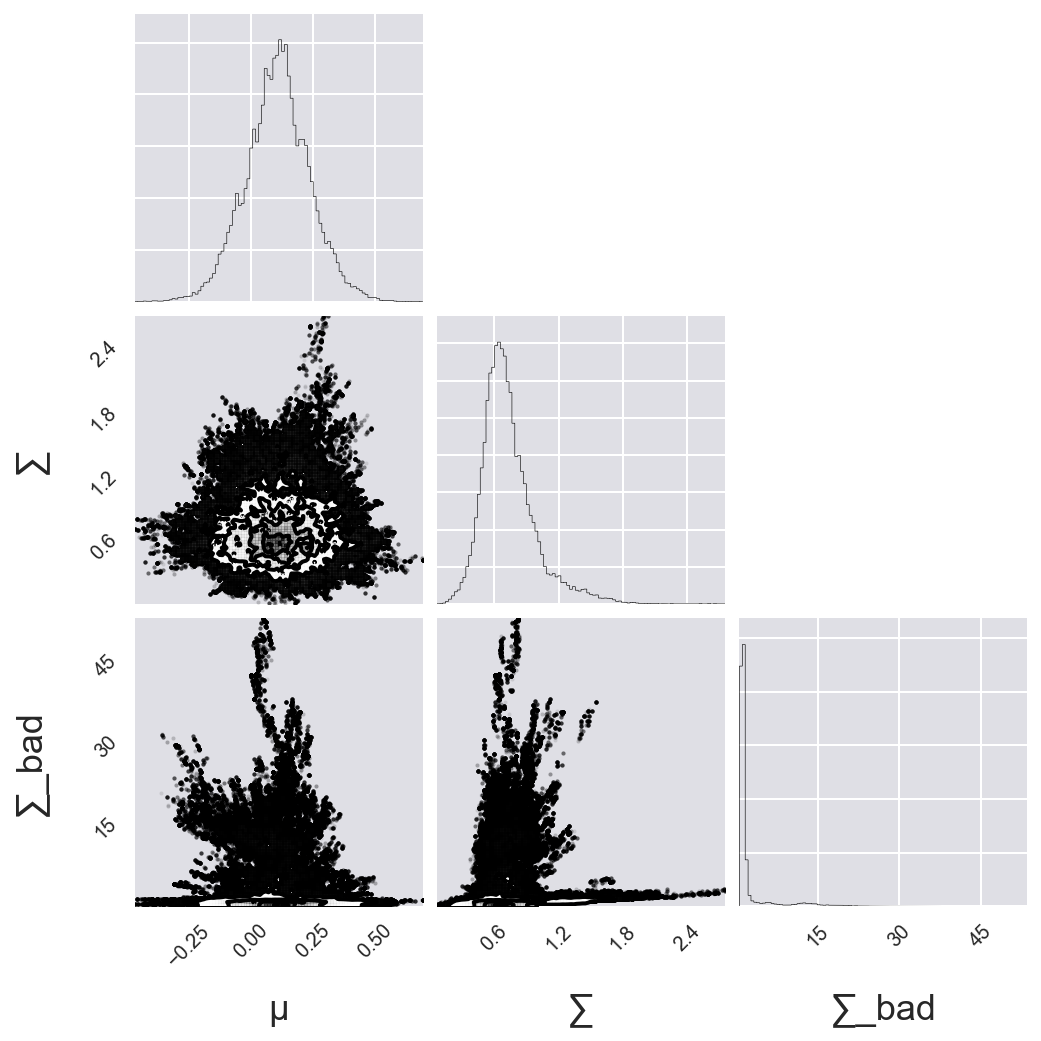

In [229]:
fig = corner.corner(sampler.flatchain[:, 0:3], labels=['µ', '∑', '∑_bad'], bins=100)

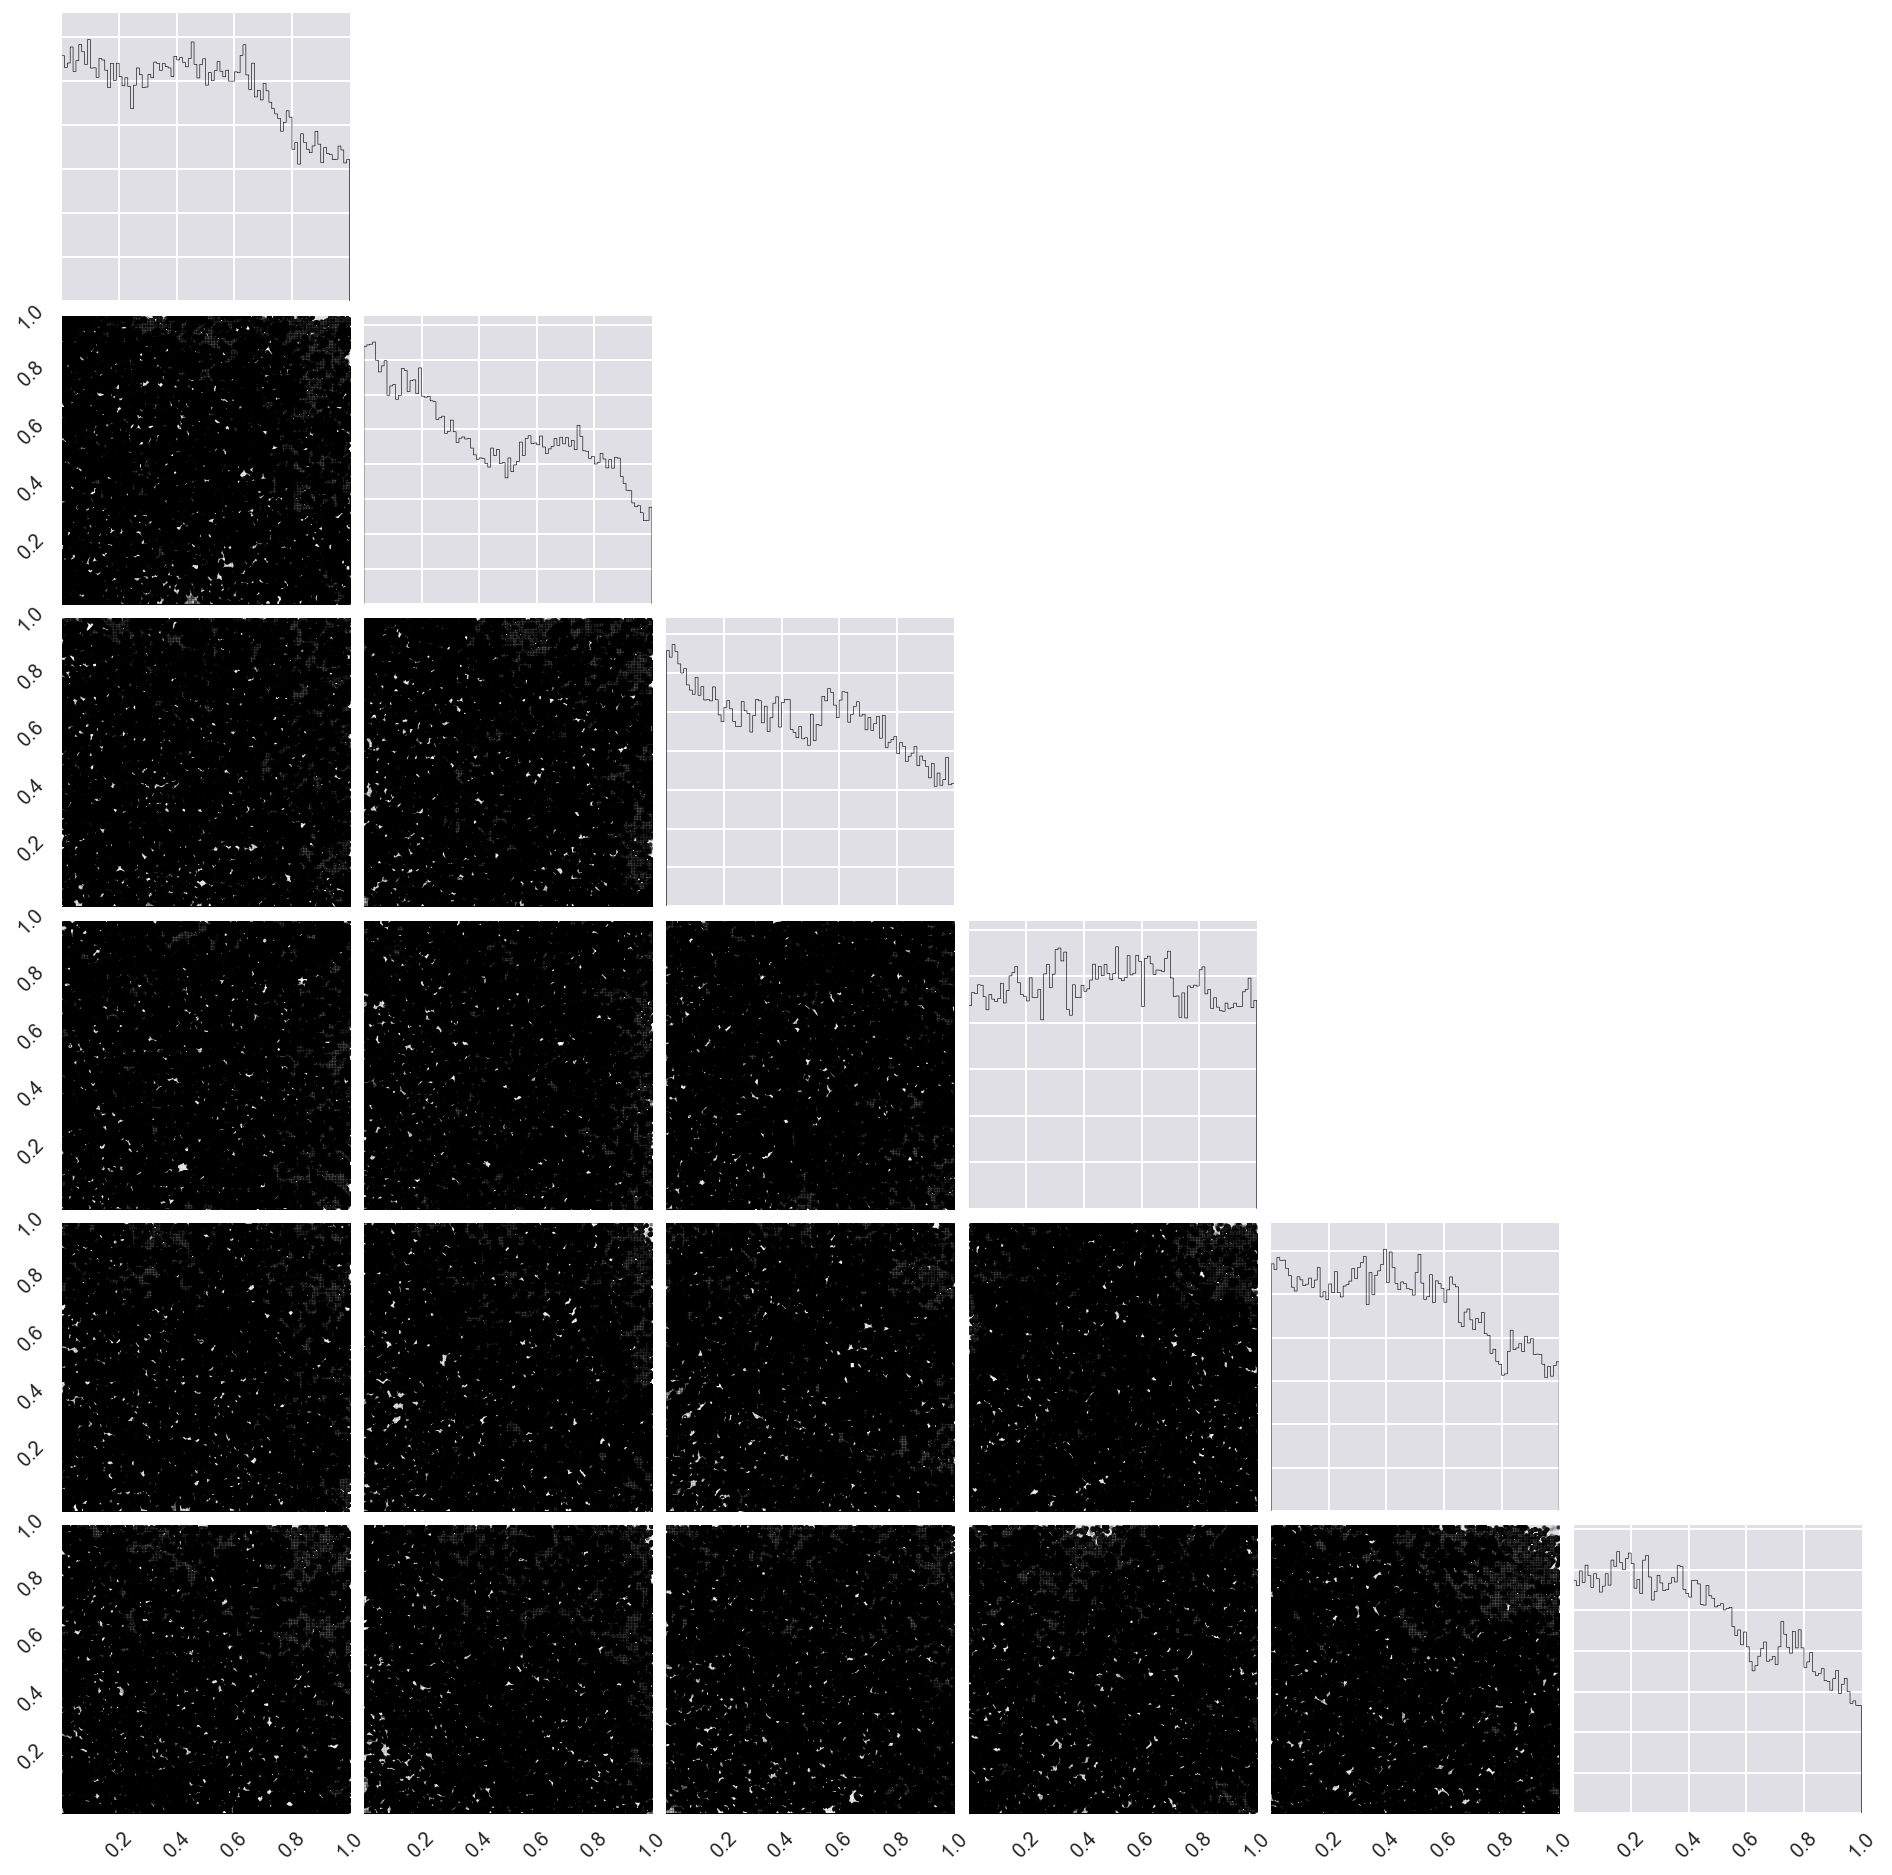

In [233]:
fig = corner.corner(sampler.flatchain[:, 22:], bins=100)

In [234]:
mean= sampler.flatchain[:, 0].mean(axis=0)
sigma= sampler.flatchain[:, 1].mean(axis=0)
sb= sampler.flatchain[:, 2].mean(axis=0)
print( 'mean: {0:2f}\nsigma: {1:2f}\nsigma_bad: {2:2f}'.format(mean, sigma, sb))

mean: 0.107324
sigma: 0.734739
sigma_bad: 2.468100


# Compare these results with standard t-testing

In [237]:
from scipy import stats

In [238]:
df.head()

,rnai,alive,dead,date,gene,fraction_dead,z_dead
11,03c2,22,29,12-May-16,B0432.13,0.568627,0.200329
12,03c2,37,13,12-May-16,B0432.13,0.260000,-1.130966
10,03c2,36,14,12-May-16,B0432.13,0.280000,-1.044694
85,11a1,29,20,16-May-16,C14C10.2,0.408163,-0.491849
86,11a1,16,31,16-May-16,C14C10.2,0.659574,0.592638


In [251]:
stat_test_group = df.groupby(['gene', 'date'])

print('by date')
for name, group in stat_test_group:
    gene, date= name
    gg = df[(df.gene == 'gfp') & (df.date == date)].z_dead
    if gene is not 'gfp':
        x = df[(df.gene == gene) & (df.date == date)].z_dead
        pval = stats.ttest_ind(gg, x, equal_var = False)[1]
        if pval < 0.05:
            print('{0}: pval = {1:2f}'.format(gene, pval)    

print('\n\n\nno grouping')
gg = df[(df.gene == 'gfp')].z_dead
for gene in df.gene.unique():
    if gene is not 'gfp':
        x = df[df.gene == gene].z_dead
        pval = stats.ttest_ind(gg, x, equal_var = False)[1]
        if pval < 0.05:
            print('{0}: pval = {1:2f}'.format(gene, pval)

by date
T12G3.2: pval = 0.004089
cnt-2: pval = 0.017075
twk-8: pval = 0.002904



no grouping
F54E12.2: pval = 0.017809
R08D7.4: pval = 0.032797
T12G3.2: pval = 0.000026
cnt-2: pval = 0.012740
egl-15: pval = 0.009514
twk-8: pval = 0.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

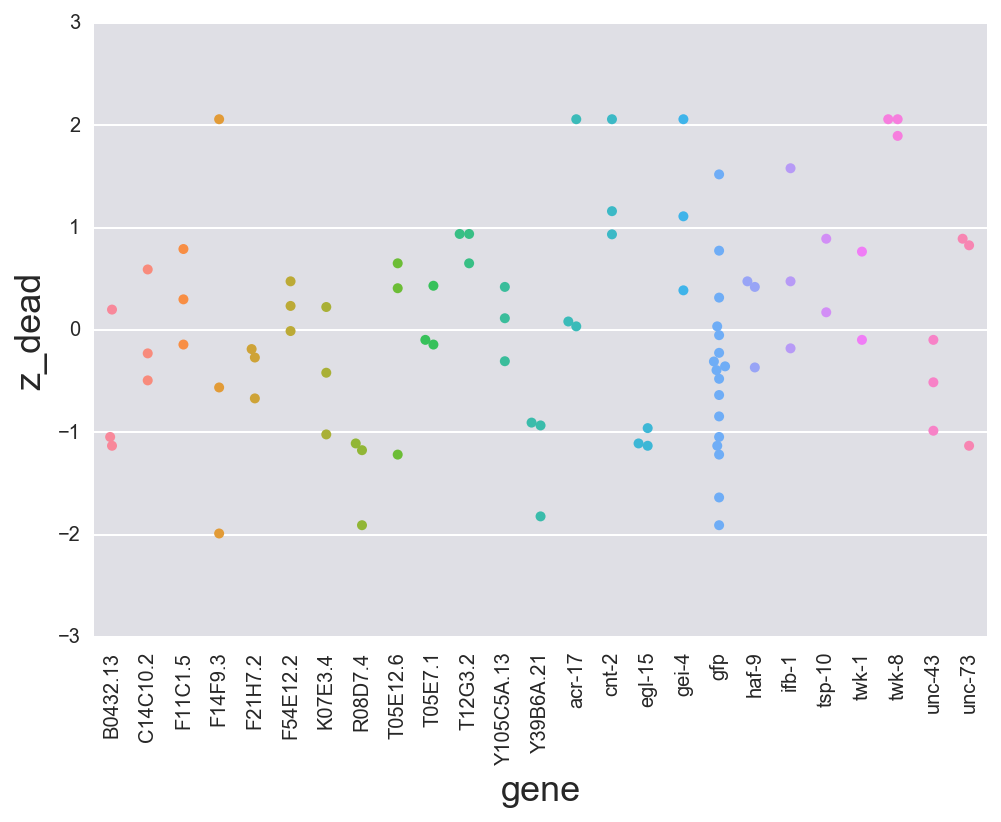

In [253]:
sns.swarmplot(x='gene', y='z_dead', data=df)
plt.xticks(rotation=90)